# Import and Setup Stuff

In [ ]:
import pickle
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
!pip install emoji
!pip install vaderSentiment
from emoji import UNICODE_EMOJI
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from google.colab import drive
!pip install TextBlob
from textblob import TextBlob
from textblob import Word
#mount google drive 
drive.mount('/content/drive')
#Download and unzip files
# added example
!ls "/content/drive/My Drive"
!sudo apt-get install unzip
!pwd
####################################
# example text 
file_tina = "/content/drive/My Drive/tinas_comments.csv"
file_ken = "/content/drive/My Drive/kens_comments.csv"
file_debate1 = "/content/drive/My Drive/debate1_comments.csv"

df_tina = pd.read_csv(file_tina)
df_ken = pd.read_csv(file_ken)
df_debate1 = pd.read_csv(file_debate1)

In [ ]:
# concat comments
df_tina['channel_name']='Tina Huang'
df_ken['channel_name']='Ken Jee'
df = pd.concat([df_tina, df_ken])
df.head()

,Unnamed: 0,comment,comment_id,author_url,author_name,reply_count,like_count,date,vidid,total_reply_counts,vid_title,just_date,channel_name
0,0,Big thumbs up!! Very clearly explained. Really...,Ugx-FYMM1gPsoN3hw1B4AaABAg,http://www.youtube.com/channel/UCr4wD1q2l3_hQE...,mintao Wei,0,0,2020-11-25 13:19:04+00:00,Td-cmLfQ7uU,0,Real Data Science SQL Interview Questions and ...,2020-11-25,Tina Huang
1,1,0:53 This private method earn 5000$ in 2 days ...,Ugw7wRaJzx5-wH4-tt14AaABAg,http://www.youtube.com/channel/UCEu06fgOkZxU2F...,Nike Nike,0,0,2020-11-25 08:03:22+00:00,mqc46gdNs4E,0,3 tips to avoid debt for a masters #SHORTS,2020-11-25,Tina Huang
2,2,Really thank you for this interview! and..I ha...,Ugws1BT5twvi6Lh108R4AaABAg,http://www.youtube.com/channel/UCk3sYdoFS53UHP...,heskeybi,0,0,2020-11-25 01:47:44+00:00,KsQU_3n0IYE,0,My UPenn MCIT Experience,2020-11-25,Tina Huang
3,3,They've changed the table so now your way is n...,Ugyz9y1UGg99d7y4Ko14AaABAg,http://www.youtube.com/channel/UCNP0onnHGAkmSR...,Chengzhu Zhang,0,0,2020-11-24 18:31:57+00:00,1u1GT4sdvdA,0,SQL Data Science Interview Questions and Answe...,2020-11-24,Tina Huang
4,4,Is your first degree is really Doctor ?,Ugwh3sSSgcH__aMEqMF4AaABAg,http://www.youtube.com/channel/UC7waw3QMuxE9zN...,V.R. SANTHOSH,0,0,2020-11-24 15:58:08+00:00,C8iL4V-y1Qs,0,How I chose my masters degree (as an internati...,2020-11-24,Tina Huang


In [ ]:
# remove self comments 
comments = df.query('author_name != "Tina Huang" & author_name != "Ken Jee"')
comments.tail()

,Unnamed: 0,comment,comment_id,author_url,author_name,reply_count,like_count,date,vidid,total_reply_counts,vid_title,just_date,channel_name
5823,5823,"Dear Ken,\nMay I know how the input data with ...",UgzX5v48CJAPbvynwTR4AaABAg,http://www.youtube.com/channel/UCR6Aw5FBLgmBb4...,小果粒的专职铲屎官,1,0,2018-07-06 07:08:39+00:00,qfRhKHV8-t4,1,Predicting Crypto-Currency Price Using RNN lST...,2018-07-06,Ken Jee
5824,5824,What's your prediction Ken for 2018 or at leas...,UgwdI9ydb2nk-FIJ1sN4AaABAg,http://www.youtube.com/channel/UCjgbXJ4GkPcjhv...,M K,0,0,2018-05-15 00:01:12+00:00,qfRhKHV8-t4,0,Predicting Crypto-Currency Price Using RNN lST...,2018-05-15,Ken Jee
5825,5825,Nice. I have some nice models for this doing v...,UgyTi5fEIpZBoED9Fc94AaABAg,http://www.youtube.com/channel/UCvvT56bsy3PueQ...,TensorTom,0,0,2018-05-04 20:58:54+00:00,qfRhKHV8-t4,0,Predicting Crypto-Currency Price Using RNN lST...,2018-05-04,Ken Jee
5826,5826,Great video! Can you please post the github li...,UgyhJTCKn88b0lggR794AaABAg,http://www.youtube.com/channel/UCazvqH3TM4OhJq...,Papurzin Trafalete,0,0,2018-02-20 16:46:19+00:00,qfRhKHV8-t4,0,Predicting Crypto-Currency Price Using RNN lST...,2018-02-20,Ken Jee
5827,5827,Hi Ken\n\nI've been researching about this. Wo...,UgzG1dz-KieX_gxjMWd4AaABAg,http://www.youtube.com/channel/UCOTrNy9kY6HdBd...,karthik d,6,2,2017-12-03 18:52:35+00:00,qfRhKHV8-t4,6,Predicting Crypto-Currency Price Using RNN lST...,2017-12-03,Ken Jee


In [ ]:
# choose who's comments 
comments = comments.query('channel_name == "Ken Jee"')
debate_comments = df_debate1

In [ ]:
# brief clean up
def preprocess(comment):
    comment = comment.str.replace("\n", " ") # remove new lines 
    return comment

comments['comment'] = preprocess(comments['comment'])

# Get Vader Sentiments

In [ ]:
# @Ken Jee https://www.youtube.com/channel/UCiT9RITQ9PW6BhXK0y2jaeg
# https://towardsdatascience.com/sentimental-analysis-using-vader-a3415fef7664
sentiment = SentimentIntensityAnalyzer()
sentiment.polarity_scores(comments.comment[0])
comments['vader_sentiment'] = comments.comment.apply(lambda x: sent.polarity_scores(x))
comments['vader_neg_sentiment'] = comments.vader_sentiment.apply(lambda x: x['neg'])
comments['vader_pos_sentiment'] = comments.vader_sentiment.apply(lambda x: x['pos'])
comments['vader_comp_sentiment'] = comments.vader_sentiment.apply(lambda x: x['compound'])

In [ ]:
# most positive 
comments.sort_values(by=['vader_comp_sentiment'], ascending=False)[['comment']].head(10)

In [ ]:
# most negative 
comments.sort_values(by=['vader_comp_sentiment'], ascending=True)[['comment']].head(10)

# Get Textblob Sentiments

In [ ]:
## Another method 
## credit: https://towardsdatascience.com/a-complete-exploratory-data-analysis-and-visualization-for-text-data-29fb1b96fb6a
comments['textblob_polarity'] = comments['comment'].map(lambda text: TextBlob(text).sentiment.polarity)
comments['comment_len'] = comments['comment'].astype(str).apply(len)
comments['word_count'] = comments['comment'].apply(lambda x: len(str(x).split()))

In [ ]:
# most positive comments
comments.sort_values(by=['textblob_polarity'], ascending=False)[['comment', 'textblob_polarity']].head(10)

In [ ]:
# most negative
comments.sort_values(by=['textblob_polarity'], ascending=True)[['comment', 'textblob_polarity']].head(10)

In [ ]:
# most neutral 
#questions? 
textblob_neutral = comments.query('textblob_polarity == 0').rename(columns={"comment": "textblob_comment"})[['textblob_comment']].reset_index(drop=True)
vader_neutral = comments.query('vader_comp_sentiment == 0').rename(columns={"comment": "vader_comment"})[['vader_comment']].reset_index(drop=True)
vader_neutral # probably should correct spelling errors with textblob 

# Exploratory

In [ ]:
# most number of likes
pd.set_option('display.max_colwidth', None)
comments.sort_values(by=['like_count'], ascending=False)[['comment']].head(10)

In [ ]:
# comparison of textblob and vader sentiment distribution
sub = comments[['comment', 'textblob_polarity', 'vader_comp_sentiment', 'just_date', 'vidid', 'comment_len', 'word_count']]
pol_hist = sub.melt(id_vars=['comment', 'just_date', 'vidid', 'comment_len', 'word_count'], value_vars=['textblob_polarity', 'vader_comp_sentiment'], var_name='method', value_name='sentiment')
sns.displot(pol_hist, x="sentiment",hue="method", element="step")

In [ ]:
# comment_len 
only_textblob = pol_hist.query('method == "textblob_polarity"')
sns.displot(only_textblob, x="comment_len")

In [ ]:
sns.displot(only_textblob, x="word_count")

In [ ]:
# videos with highest and lowest sentiments 
# highest 
# lowest
comments.groupby('vid_title').mean()[['textblob_polarity']].sort_values(by=['textblob_polarity'], ascending=True)

[Text(0, 0, 'How I Would Learn Data Science (If I Had to Start Over)'),
 Text(0, 0, 'The Best Free Data Science Courses Nobody is Talking About'),
 Text(0, 0, 'Beginner Kaggle Data Science Project Walk-Through (Titanic)'),
 Text(0, 0, '3 Proven Data Science Projects for Beginners (Kaggle)'),
 Text(0, 0, 'Data Science Certificate vs Bootcamp vs Masters Degree'),
 Text(0, 0, 'Data Science Project from Scratch - Part 2 (Data Collection)'),
 Text(0, 0, 'Building a Deep Learning BEAST (NVIDIA TITAN RTX + RYZEN 3900X)'),
 Text(0, 0, "Why I'm Starting Data Science Over Again."),
 Text(0, 0, 'Scrape Twitter Data in Python with Twitterscraper Module'),
 Text(0, 0, '5 Essential Data Science Projects for Your Portfolio')]

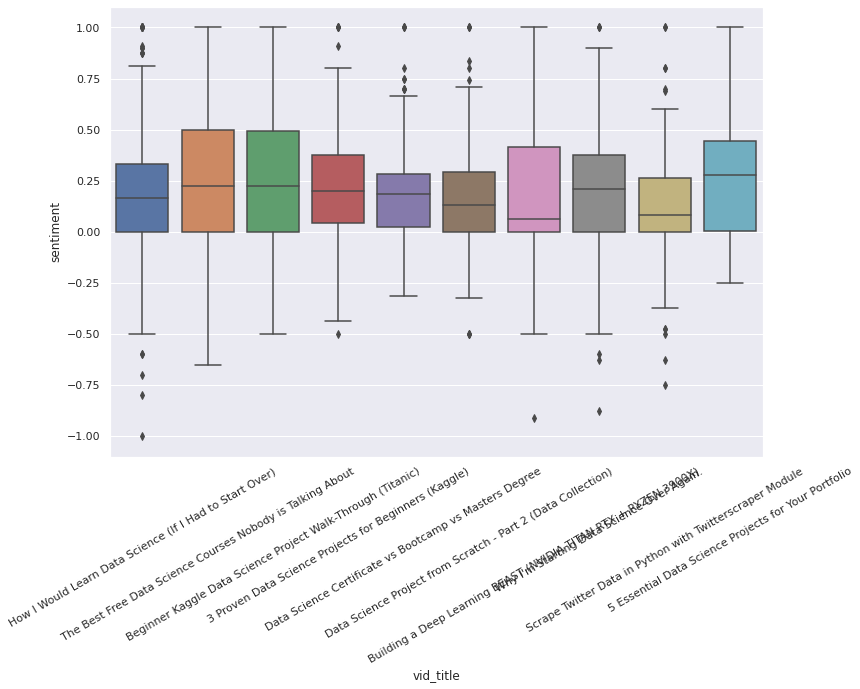

In [ ]:
# sentiment per videos
import matplotlib.pylab as plt
sns.set(rc={'figure.figsize':(11.7,8.27)}) 
ax = sns.boxplot(x="vid_title", y="sentiment", data=vidid_pol_hist)
ax.set_xticklabels(ax.get_xticklabels(),rotation=30)

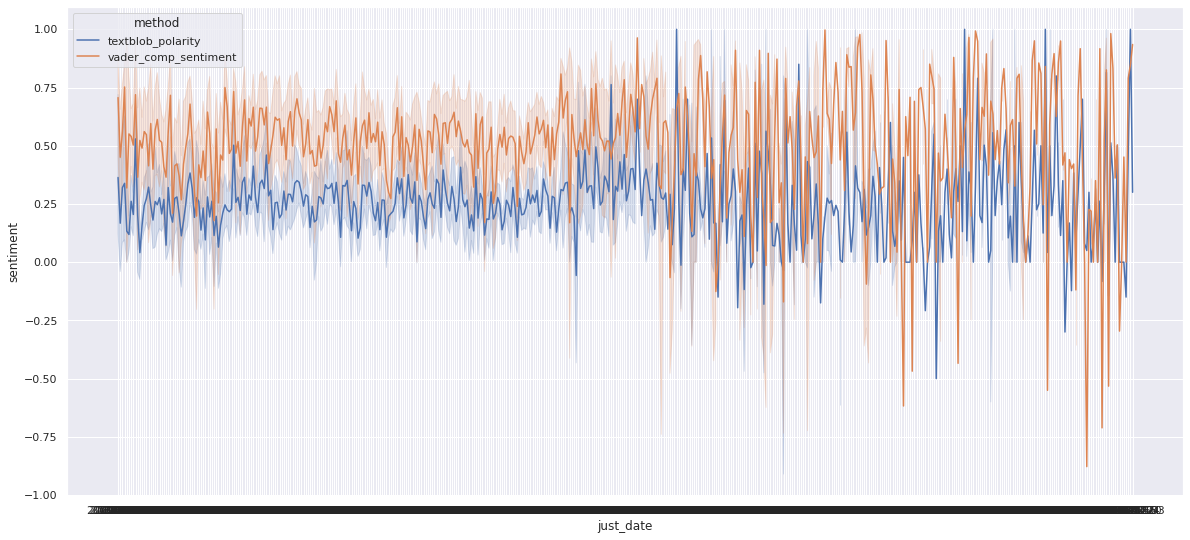

In [ ]:
# sentiments over time 
sns.set(rc={'figure.figsize':(20,9)})
sns.lineplot(x="just_date", y="sentiment", hue="method", data=pol_hist) 

# Get most defining words for the channel/video 

First we get a "corpus" or a body of words from spacy's pre-trained model that was trained on A LOT of text and lots of fancy processing. As they put it "English multi-task CNN trained on OntoNotes. Assigns context-specific token vectors, POS tags, dependency parse and named entities." https://spacy.io/models/en

Then we take our comments, transform it into a Scattertext Corpus, and find the words that are the most unlike this spacy corpus that represents the general english language aka. the words that define the channel/video. 



In [ ]:
# https://towardsdatascience.com/a-complete-exploratory-data-analysis-and-visualization-for-text-data-29fb1b96fb6a
!pip install scattertext
import spacy.cli
spacy.cli.download("en_core_web_lg")
import scattertext as st

     |████████████████████████████████| 7.3MB 3.8MB/s 
  Created wheel for flashtext: filename=flashtext-2.7-py2.py3-none-any.whl size=9298 sha256=128ebd08cb1b0cd0383982760c21cc08234c047d0fb3fe250572ead268d1f17d
  Stored in directory: /root/.cache/pip/wheels/37/db/d7/fe74f7cb8e5c3afed90fe6f4967c933a6f13d81ab6b3d3128c
Successfully built flashtext
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_md')


In [ ]:
nlp = spacy.load('en_core_web_lg')

In [ ]:
corpus = st.CorpusFromPandas(only_textblob, category_col='vidid', text_col='comment', nlp=nlp).build()
# terms that differentiate text from background text 
print(list(corpus.get_scaled_f_scores_vs_background().index[:20]))

['kaggle', 'github', 'tweets', 'youtube', 'jee', 'coursera', 'jupyter', 'udemy', 'twitter', 'linkedin', 'datascience', 'glassdoor', 'datacamp', 'youtubers', 'numpy', 'ken', 'twitterscraper', 'bootcamp', 'covid', 'colab']


# K Means Clustering of Debate Comments

In [ ]:
# https://medium.com/@rohithramesh1991/unsupervised-text-clustering-using-natural-language-processing-nlp-1a8bc18b048d
# https://github.com/rohithramesh1991/Text-Preprocessing/blob/master/Text%20Preprocessing_codes.py
# https://stackoverflow.com/questions/51217909/removing-all-emojis-from-text 
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from nltk.tokenize import RegexpTokenizer
from nltk.stem.snowball import SnowballStemmer
%matplotlib inline

In [ ]:
# text preprocessing
"""removes punctuation, stopwords, and returns a list of the remaining words, or tokens"""
import string
import emoji
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from nltk.tokenize import RegexpTokenizer
from nltk.stem.snowball import SnowballStemmer
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.stem import PorterStemmer, WordNetLemmatizer

# remove emojis 
def give_emoji_free_text(text):
    allchars = [str for str in text]
    emoji_list = [c for c in allchars if c in emoji.UNICODE_EMOJI]
    clean_text = ' '.join([str for str in text.split() if not any(i in str for i in emoji_list)])
    return clean_text


def text_process(text):
    # stemmer = WordNetLemmatizer()
    stemmer = PorterStemmer()
    nopunc = [char for char in text if char not in string.punctuation]
    nopunc = ''.join([i for i in nopunc if not i.isdigit()])
    nopunc =  [word.lower() for word in nopunc.split() if word not in stopwords.words('english')]
    # temp = [stemmer.lemmatize(word) for word in nopunc]
    temp = [stemmer.stem(word) for word in nopunc]

    joined = ' '.join(temp)
    # remove emojis 
    joined = give_emoji_free_text(joined)

    # correct spelling 
    # joined = str(TextBlob(joined).correct())

    return joined.split()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [ ]:
##kmeans
desc = debate_comments['comment'].values 
vectorizer4 = TfidfVectorizer(analyzer = text_process, stop_words=stopwords.words('english'), ngram_range=(1,3))
X4 = vectorizer4.fit_transform(desc)
words = vectorizer4.get_feature_names()


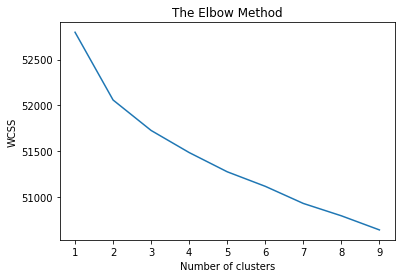

In [ ]:
wcss = []
for i in range(1,10):
    kmeans = KMeans(n_clusters=i,init='k-means++',max_iter=300,n_init=10,random_state=0)
    kmeans.fit(X4)
    wcss.append(kmeans.inertia_)
plt.plot(range(1,10),wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.savefig('elbow.png')
plt.show()

In [ ]:
kmeans = KMeans(n_clusters = 2, n_init = 20, n_jobs = 1) # n_init(number of iterations for clsutering) n_jobs(number of cpu cores to use)
kmeans.fit(X4)
# We look at 2 the clusters generated by k-means.
common_words = kmeans.cluster_centers_.argsort()[:,-1:-26:-1]
for num, centroid in enumerate(common_words):
    print(str(num) + ' : ' + ', '.join(words[word] for word in centroid))

0 : trump, biden, i, debat, joe, like, presid, thi, the, moder, vote, peopl, watch, fuck, talk, wallac, he, go, get, one, america, time, say, shut, chri
1 : trump, fuck, go, vote, biden, presid, debat, like, one, moder, joe, savag, get, behav, peopl, walk, beauti, clearli, piec, i, bless, support, heard, love, anoth
